# Sankey Diagram

---

## Exportação e importação (visualização em sankey)
- Usando plotly

### Tratamento dos dados

* Pegando dataset de exportação e importação realizados no mundo no ano de 2024

In [2]:
import pandas as pd

import plotly.graph_objects as go
import plotly.express as px  #paletas

d3_colors = px.colors.qualitative.D3

In [3]:
cols=[
    'period','flowCode', 'reporterDesc', 'reporterISO', 'partnerDesc', 'partnerISO', 'refYear', 'primaryValue'
]

#lendo o dataset
df = pd.read_excel("TradeData.xlsx", usecols=cols) #todas exportações de 2024
df.head()
map_df = pd.read_csv("country_continent_full.csv") #dataset de ISO/PAIS/CONTINENTE


* Unindo o dataset das infos de ISO-continente com o df existente

In [4]:
# Merge df e map_df 
df = pd.merge(df, map_df, left_on='partnerISO', right_on='ISO3', how='left')

df.rename(columns={'Continent': 'partner continent'}, inplace=True)

df.drop(['Country','ISO3'], axis=1, inplace=True)

display(df.head())

refYear  period reporterISO reporterDesc flowCode partnerISO  \
0     2024    2024         ALB      Albania        M        W00   
1     2024    2024         ALB      Albania        M        AFG   
2     2024    2024         ALB      Albania        M        ATA   
3     2024    2024         ALB      Albania        M        DZA   
4     2024    2024         ALB      Albania        M        ASM   

      partnerDesc  primaryValue partner continent  
0           World  9.604259e+09               NaN  
1     Afghanistan  5.307800e+02     Other/Unknown  
2      Antarctica  6.387660e+02     Other/Unknown  
3         Algeria  7.587345e+07            Africa  
4  American Samoa  4.946630e+03     Other/Unknown

In [5]:
#Todas as exportações do Brasil

brazilExp = df[(df['reporterISO'] == 'BRA') & (df['flowCode'] == 'X') & (df['partnerISO'] != 'W00')]
brazilImp = df[(df['reporterISO'] == 'BRA') & (df['flowCode'] == 'M') & (df['partnerISO'] != 'W00')]

brazilExp.head()

refYear  period reporterISO reporterDesc flowCode partnerISO  \
4381     2024    2024         BRA       Brazil        X        AFG   
4382     2024    2024         BRA       Brazil        X        ALB   
4383     2024    2024         BRA       Brazil        X        ATA   
4384     2024    2024         BRA       Brazil        X        DZA   
4385     2024    2024         BRA       Brazil        X        ASM   

         partnerDesc  primaryValue partner continent  
4381     Afghanistan  3.098084e+06     Other/Unknown  
4382         Albania  1.005799e+08            Europe  
4383      Antarctica  1.272530e+05     Other/Unknown  
4384         Algeria  2.567007e+09            Africa  
4385  American Samoa  8.736590e+05     Other/Unknown

##  

#### 1. Primeira visualização: exportação brasil -> seus top n parceiros 

In [6]:
# Filtrar Brasil exportações
brazilExp = df[(df['reporterISO'] == 'BRA') &
               (df['flowCode'] == 'X') &
               (df['partnerISO'] != 'W00')]

# Top n parceiros por valor
n = 15

top_partners = brazilExp.groupby("partnerDesc")["primaryValue"].sum().nlargest(n).reset_index()

# Criar labels (Brasil + parceiros)
labels = ["Brazil"] + top_partners["partnerDesc"].tolist()

# Links
source = [0] * len(top_partners)  # sempre Brasil
target = list(range(1, len(labels)))  # cada parceiro
value = top_partners["primaryValue"].tolist()



def hex_to_rgba(hex_color: str, alpha: float = 0.5) -> str:
    h = hex_color.lstrip('#')
    r, g, b = int(h[0:2], 16), int(h[2:4], 16), int(h[4:6], 16)
    return f'rgba({r},{g},{b},{alpha})'

palette = {label: d3_colors[i % len(d3_colors)] for i, label in enumerate(labels)}

# cores dos nós na mesma ordem de 'labels'
node_colors = [palette[label] for label in labels]

# cores dos links herdando a cor do nó de origem (links_source são índices de 'labels')
link_colors = [hex_to_rgba(palette[labels[s]], 0.5) for s in source]


# Construir Sankey
fig = go.Figure(data=[go.Sankey(
    node=dict(
        pad=15,
        thickness=20,
        line=dict(color="black", width=0.5),
        label=labels,
        color=node_colors
    ),
    link=dict(
        source=source,
        target=target,
        value=value,
        color=link_colors
    )
)])

fig.update_layout(title_text=f" 🌎 Exportações do Brasil - Top {n} Parceiros", font_size=12)
fig.show()


#### 2. Adicionando mais um nó ao grafico, permitindo informação de quantidade exportada por continente e por pais

In [7]:
# Filtrar Brasil exportações
brazilExp = df[(df['reporterISO'] == 'BRA') &
               (df['flowCode'] == 'X') &
               (df['partnerISO'] != 'W00')]

# Top n países por valor (agrupando também por continente)

n = 20
top_partners = brazilExp.groupby(["partnerDesc", "partner continent"])["primaryValue"].sum().nlargest(20).reset_index()

# Labels
labels = ["Brazil"]
continents = top_partners["partner continent"].unique().tolist()
labels.extend(continents)
labels.extend(top_partners["partnerDesc"].tolist())

# Índices para lookup
label_index = {label: i for i, label in enumerate(labels)}

# Links Brasil → Continente
links_source = []
links_target = []
links_value = []

for cont in continents:
    value = top_partners[top_partners["partner continent"] == cont]["primaryValue"].sum()
    links_source.append(label_index["Brazil"])
    links_target.append(label_index[cont])
    links_value.append(value)

# Links Continente → País
for _, row in top_partners.iterrows():
    links_source.append(label_index[row["partner continent"]])
    links_target.append(label_index[row["partnerDesc"]])
    links_value.append(row["primaryValue"])


d3_colors = px.colors.qualitative.D3  # category10

def hex_to_rgba(hex_color: str, alpha: float = 0.5) -> str:
    h = hex_color.lstrip('#')
    r, g, b = int(h[0:2], 16), int(h[2:4], 16), int(h[4:6], 16)
    return f'rgba({r},{g},{b},{alpha})'

# mapa label → cor (estável)
palette = {label: d3_colors[i % len(d3_colors)] for i, label in enumerate(labels)}

# cores dos nós, na ordem de 'labels'
node_colors = [palette[label] for label in labels]

# cores dos links herdando a cor do nó de ORIGEM
link_colors = [hex_to_rgba(palette[labels[s]], 0.5) for s in links_source]

# Sankey
fig = go.Figure(data=[go.Sankey(
    node=dict(
        pad=20,
        thickness=20,
        line=dict(color="black", width=0.5),
        label=labels,
        color=node_colors
    ),
    link=dict(
        source=links_source,
        target=links_target,
        value=links_value,
        color=link_colors
    )
)])


fig.update_layout(title_text="🌎 Exportações do Brasil - Brasil → Continente → País (20)", font_size=12)
fig.show()

In [ ]:
tradedf = pd.DataFrame()
source_labels = [labels[i] for i in links_source]
target_labels = [labels[i] for i in links_target]
tradedf.insert(0, "Source", source_labels)
tradedf.insert(1, "Target", target_labels)
tradedf.insert(2, "Value", links_value)
tradedf.to_csv("brasiltrade.csv")

#### 3.Representação com todos os parceiros comerciais do Brasil, gerando uma visualização comprometida

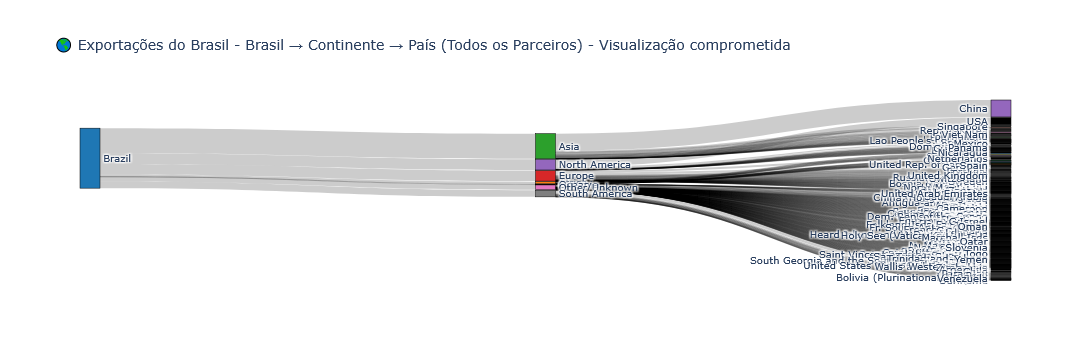

In [12]:
# Filtrar Brasil exportações
brazilExp_all = df[(df['reporterISO'] == 'BRA') &
                  (df['flowCode'] == 'X') &
                  (df['partnerISO'] != 'W00')].copy()

# Group by continent and then by country
continent_agg = brazilExp_all.groupby('partner continent')['primaryValue'].sum().reset_index()
country_agg = brazilExp_all.groupby(['partner continent', 'partnerDesc'])['primaryValue'].sum().reset_index()

# Labels
labels = ["Brazil"]
continents = continent_agg["partner continent"].tolist()
labels.extend(continents)
labels.extend(country_agg["partnerDesc"].tolist())

# Índices para lookup
label_index = {label: i for i, label in enumerate(labels)}

# Links Brasil → Continente
links_source = []
links_target = []
links_value = []

for _, row in continent_agg.iterrows():
    links_source.append(label_index["Brazil"])
    links_target.append(label_index[row["partner continent"]])
    links_value.append(row["primaryValue"])

# Links Continente → País
for _, row in country_agg.iterrows():
    if row["partner continent"] in label_index and row["partnerDesc"] in label_index:
        links_source.append(label_index[row["partner continent"]])
        links_target.append(label_index[row["partnerDesc"]])
        links_value.append(row["primaryValue"])


# Sankey
fig = go.Figure(data=[go.Sankey(
    node=dict(
        pad=15,
        thickness=20,
        line=dict(color="black", width=0.5),
        label=labels,
        color=node_colors
    ),
    link=dict(
        source=links_source,
        target=links_target,
        value=links_value,
    )
)])

fig.update_layout(title_text="🌎 Exportações do Brasil - Brasil → Continente → País (Todos os Parceiros) - Visualização comprometida", font_size=10)
fig.show()

-----

In [ ]:
### Dados das traduções feitas em programas de pós graduação brasileiros visualizada em Sankey

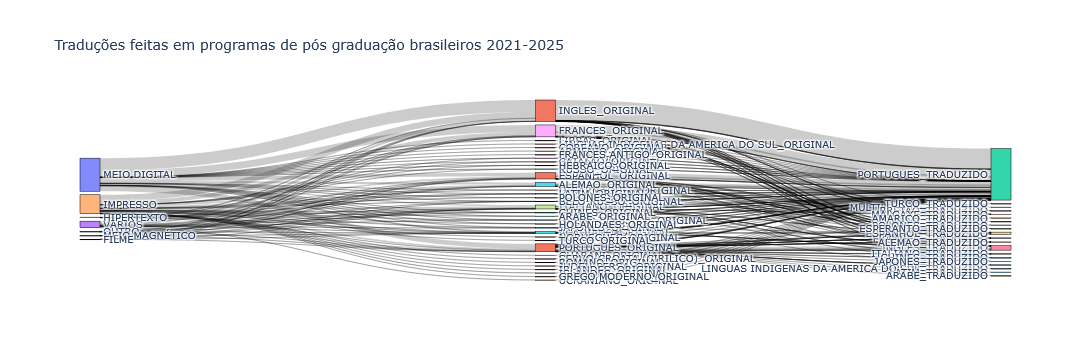

In [20]:
import json

with open("traducoes_brutas.json") as traducoes_file:
    data_traducoes = json.load(traducoes_file)

fig = go.Figure(data=[go.Sankey(
    node = dict(
      pad = 15,
      thickness = 20,
      line = dict(color = "black", width = 0.5),
      label = list(data_traducoes["labels"])
    ),
    link = dict(
      source = data_traducoes["source"],
      target = data_traducoes["target"],
      value = data_traducoes["value"]
  ))])
        
fig.update_layout(title_text="Traduções feitas em programas de pós graduação brasileiros 2021-2025", font_size=10)
fig.show()


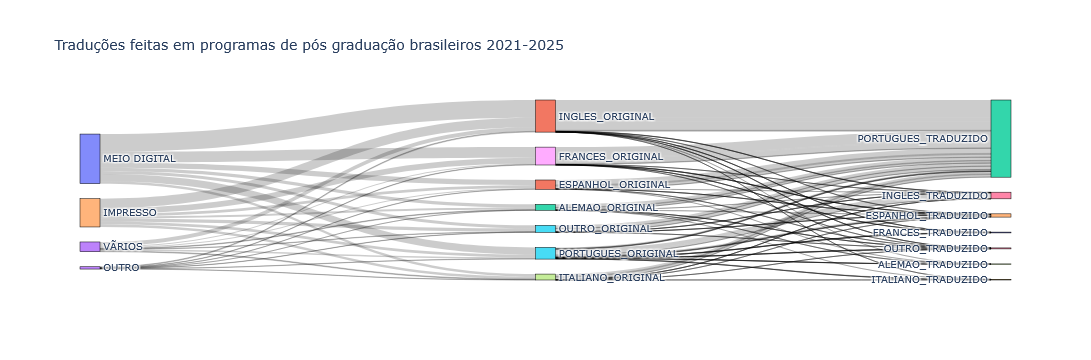

In [24]:
import json

with open("traducoes_limpas.json") as traducoes_file:
    data_traducoes = json.load(traducoes_file)

fig = go.Figure(data=[go.Sankey(
    node = dict(
      pad = 15,
      thickness = 20,
      line = dict(color = "black", width = 0.5),
      label = list(data_traducoes["labels"])
    ),
    link = dict(
      source = data_traducoes["source"],
      target = data_traducoes["target"],
      value = data_traducoes["value"]
  ))])
        
fig.update_layout(title_text="Traduções feitas em programas de pós graduação brasileiros 2021-2025", font_size=10)
fig.show()
